In [1]:
%load_ext autoreload
%autoreload 2

from data_util import *

In [2]:
snr_per_bin = 23
file_id = './data_products/systematic_marginalized_velocity_dispersion_snr_per_bin_{}'.format(snr_per_bin)

binned_dispersion = np.loadtxt(file_id+'_mean.txt')
covariance = np.loadtxt(file_id+'_covariance.txt')

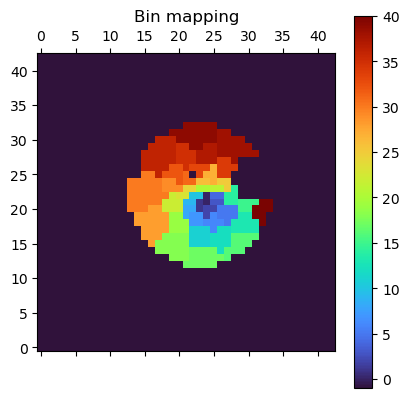

In [3]:
bin_mapping = load_bin_mapping(target_snr_per_bin=snr_per_bin, plot=True);


In [4]:
vel_dis_map = get_kinematics_maps(binned_dispersion, bin_mapping)

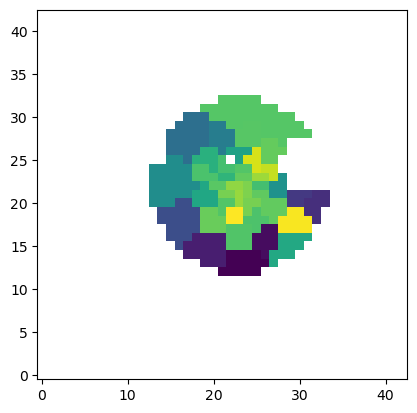

In [5]:
vel_dis_map_copy = np.copy(vel_dis_map)
vel_dis_map_copy[vel_dis_map_copy == 0] = np.nan

plt.imshow(vel_dis_map_copy, origin='lower')

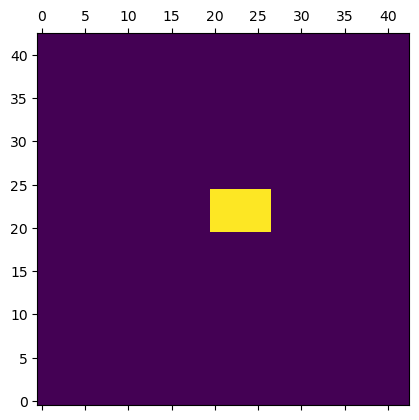

In [6]:
binning = np.zeros((43, 43))

w = 0
binning[22-2-w:22+3+w, 23-3-w:23+4+w] = np.ones((5+2*w, 7+2*w))

#binning = 1

plt.matshow(binning, origin='lower')

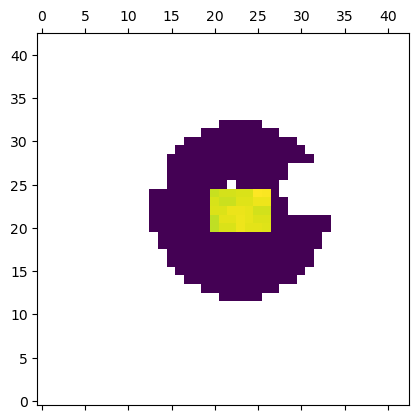

In [8]:
plt.matshow(binning*vel_dis_map_copy, origin='lower')

In [9]:
from dynamical_model import DynamicalModel


dyn_model = DynamicalModel('powerlaw')

In [10]:
amp, sigma, q_obs, pa = dyn_model.get_light_mge()

surface_brightness = dyn_model.get_surface_brightness_image(amp, sigma, 
                                       q_obs,
                                       dyn_model.X_GRID,
                                       dyn_model.Y_GRID
)



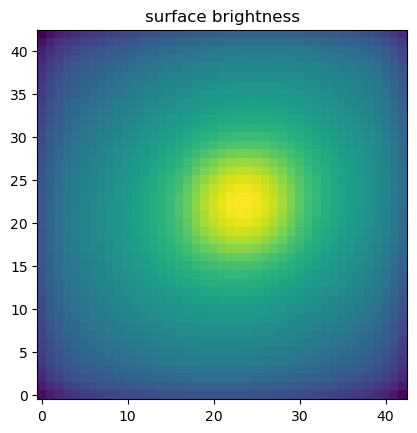

In [11]:
%matplotlib inline

from lenstronomy.LightModel.light_model import LightModel
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from dynamical_model import DynamicalModel


light_model = LightModel(['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])
dyn_model = DynamicalModel('powerlaw')

supersampling_factor = 5

x_grid, y_grid = dyn_model.get_supersampled_grid(supersampling_factor=supersampling_factor)

kwargs_light = dyn_model.get_double_sersic_kwargs(is_shperical=False)
# kwargs_light[0]['e1'] *= 10
# kwargs_light[0]['e2'] *= 10

num_pix = len(x_grid)

surface_brightness = light_model.surface_brightness(x_grid, 
                                                    y_grid, 
                                                    kwargs_light).reshape((num_pix, num_pix))


sigma = dyn_model.PSF_FWHM / 2.355 / dyn_model.PIXEL_SIZE * supersampling_factor

kernel = Gaussian2DKernel(x_stddev=sigma,
                          x_size=4 * int(sigma) + 1,
                          y_size=4 * int(sigma) + 1)

convolved_surface_brightness = convolve(surface_brightness, kernel)

convolved_surface_brightness_spaxel = convolved_surface_brightness.reshape(
            len(dyn_model.X_GRID), supersampling_factor,
            len(dyn_model.Y_GRID), supersampling_factor
        ).sum(3).sum(1)

plt.imshow(np.log10(convolved_surface_brightness_spaxel), origin='lower')
plt.title('surface brightness')
plt.show()

In [12]:
kwargs_light

[{'amp': 440.1104871319941,
  'R_sersic': 0.3002289264600075,
  'n_sersic': 1.603486540888042,
  'center_x': -0.33365299999999987,
  'center_y': 0.17921100000000006,
  'e1': 0.042743116152015544,
  'e2': -0.06940548035820797},
 {'amp': 32.64674165428045,
  'R_sersic': 2.442165342204012,
  'n_sersic': 1.1049096359154205,
  'center_x': -0.33365299999999987,
  'center_y': 0.17921100000000006,
  'e1': 0.038317165930883745,
  'e2': -0.062218704362591096}]

In [13]:
combined_sigma = np.sqrt(np.sum(binning * convolved_surface_brightness_spaxel * vel_dis_map**2) / np.sum(binning * convolved_surface_brightness_spaxel))

In [14]:
combined_sigma

287.6832324851228

In [16]:
(323 - combined_sigma) / 323 * 100

10.933983750735974